In [147]:
# adaptive gradient methods

In [257]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import pandas as pd
import torch.nn.functional as F

In [258]:
dataset = pd.read_csv("iris.csv").values

In [259]:
def preprocess(data):
    X = dataset[:,0:4].astype("float32")
    encoder = lambda y: 0 if y=="Setosa" else(1 if y == "Versicolor" else 2) 
    y = [encoder(i) for i in dataset[:,-1]]
    return X,y

In [260]:
X,y = preprocess(dataset)


In [261]:

X = torch.tensor(X)
y = torch.tensor(y)

In [292]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        
        super(NeuralNetwork,self).__init__()
        self.l1 = nn.Linear(4,4)
        self.l2 = nn.Linear(4,3)
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self,x):
        
        out = self.l1(x)
        out = self.l2(out)
        out = self.softmax(out)
        
        return out

In [293]:
model = NeuralNetwork()

In [294]:
creatrion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [295]:
# traning

losses = []


for i in range(1000):
    

    output = model(X)

    loss = creatrion(output, y)
    
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if i%100 == 0:
        losses.append(loss.item())
        print(loss.item())

1.1001086235046387
1.0979268550872803
1.0946540832519531
1.0919089317321777
1.0905354022979736
1.0897608995437622
1.0892043113708496
1.0886987447738647
1.088193416595459
1.0877118110656738


In [296]:
%matplotlib inline

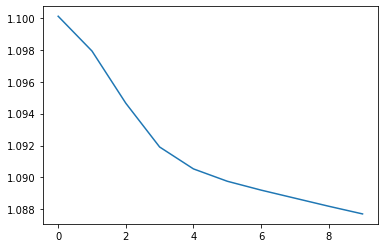

In [297]:
plt.plot(losses)